In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
from pycmqlib3.utility import dbaccess, dataseries, misc
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *
from pycmqlib3.strategy.signal_repo import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# define product groups and start times

In [4]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

# load historical data

In [5]:
fields = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2023,6,9)
shift_mode = 2
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = all_markets
nb_cont = 2
freq='d1'

data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        xdf = dataseries.nearby(prodcode,
                                nb+1,
                                start_date=start_date, 
                                end_date = end_date, 
                                shift_mode = shift_mode,
                                freq=freq, 
                                roll_name=roll_name, 
                                config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)

cdays = pd.date_range(start=start_date, end=end_date, freq='D')
bdays = pd.bdate_range(start=start_date, end=end_date, freq='C', holidays=misc.CHN_Holidays)
df.tail(5)

product         AP                                                         \
code            c1                                                          
field        close contract  diff_oi      expiry    high     low      mth   
date                                                                        
2023-06-05  8601.0   AP2310  -3695.0  2023-10-20  8671.0  8535.0  24286.0   
2023-06-06  8526.0   AP2310   3657.0  2023-10-20  8628.0  8510.0  24286.0   
2023-06-07  8525.0   AP2310  -2043.0  2023-10-20  8581.0  8492.0  24286.0   
2023-06-08  8656.0   AP2310  12603.0  2023-10-20  8698.0  8515.0  24286.0   
2023-06-09  8665.0   AP2310  -8363.0  2023-10-20  8711.0  8623.0  24286.0   

product                                                                   \
code                                                 c2                    
field         open openInterest shift    volume   close contract diff_oi   
date                                                                       
2023-06-05  8650.0     136465.0   0.0  101626.0  8408.0   AP2311   -61.0   
2023-06-06  8600.0     140122.0   0.0  104195.0  8349.0   AP2311   -23.0   
2023-06-07  8524.0     138079.0   0.0   82379.0  8356.0   AP2311    12.0   
2023-06-08  8525.0     150682.0   0.0  142005.0  8452.0   AP2311   197.0   
2023-06-09  8656.0     142319.0   0.0   88433.0  8470.0   AP2311  -339.0   

product                                                                     \
code                                                                         
field           expiry    high     low      mth    open openInterest shift   
date                                                                         
2023-06-05  2023-11-14  8477.0  8350.0  24287.0  8465.0      10483.0   0.0   
2023-06-06  2023-11-14  8424.0  8338.0  24287.0  8402.0      10460.0   0.0   
2023-06-07  2023-11-14  8397.0  8333.0  24287.0  8388.0      10472.0   0.0   
2023-06-08  2023-11-14  8497.0  8358.0  24287.0  8358.0      10669.0   0.0   
2023-06-09  2023-11-14  8502.0  8438.0  24287.0  8438.0      10330.0   0.0   

product                 CF                                                  \
code                    c1                                                   
field      volume    close contract  diff_oi      expiry     high      low   
date                                                                         
2023-06-05  409.0  16760.0   CF2309  32455.0  2023-09-14  17015.0  16315.0   
2023-06-06  383.0  16860.0   CF2309  20197.0  2023-09-14  17060.0  16685.0   
2023-06-07  426.0  16815.0   CF2309  -4555.0  2023-09-14  16955.0  16570.0   
2023-06-08  793.0  16865.0   CF2309    539.0  2023-09-14  16935.0  16720.0   
2023-06-09  667.0  16790.0   CF2309  -8865.0  2023-09-14  17070.0  16665.0   

product                                                                       \
code                                                             c2            
field           mth     open openInterest shift     volume    close contract   
date                                                                           
2023-06-05  24285.0  16340.0     620919.0   0.0  2054877.0  16665.0   CF2401   
2023-06-06  24285.0  16730.0     641118.0   0.0  1200125.0  16725.0   CF2401   
2023-06-07  24285.0  16805.0     636564.0   0.0   904044.0  16620.0   CF2401   
2023-06-08  24285.0  16770.0     637103.0   0.0   600543.0  16725.0   CF2401   
2023-06-09  24285.0  16945.0     628246.0   0.0   746945.0  16825.0   CF2401   

product                                                              \
code                                                                  
field       diff_oi      expiry     high      low      mth     open   
date                                                                  
2023-06-05   6604.0  2024-01-12  16875.0  16275.0  24289.0  16300.0   
2023-06-06   4288.0  2024-01-12  16835.0  16555.0  24289.0  16645.0   
2023-06-07   6353.0  2024-01-12  16745.0  16420.0  24289.0  16650.0 

In [6]:
asset_pairs = [('i', 'rb'), ('i', 'hc'), ('i', 'j'), ('j', 'jm'),]
beta_ret_dict = {}
betas_dict = {}
for trade_asset, index_asset in asset_pairs:
    asset_df = df[[(index_asset, 'c1', 'close'), (trade_asset, 'c1', 'close')]].copy(deep=True).droplevel([1,2], axis=1)
    asset_df = asset_df.dropna(subset=[trade_asset]).ffill()

    for asset in asset_df:
        asset_df[f'{asset}_pct'] = asset_df[asset].pct_change().rolling(5).mean()
    asset_df['beta'] = asset_df[f'{index_asset}_pct'].rolling(244).cov(asset_df[f'{trade_asset}_pct'])/asset_df[f'{index_asset}_pct'].rolling(244).var()
    key = '_'.join([trade_asset, index_asset])
    asset_df[key] = asset_df[trade_asset].pct_change() - asset_df['beta'] * asset_df[index_asset].pct_change().fillna(0)
    beta_ret_dict[key] = asset_df[key].dropna()
    betas_dict[key] = asset_df['beta']


# funda data loading/processing

In [29]:
index_map = {
    'S000020892': 'hrc_sh',
    'S000020891': 'hrc_gz',
    'S002859801': 'hrc_tj',
    'S000020890': 'hrc_bj',
    'S002859811': 'hrc_cn',
    
    'S000020868': 'rebar_sh',
    'S000020867': 'rebar_gz',
    'S000020869': 'rebar_sy',
    'S002917430': 'plate_8mm',
    'S000020903': 'crc_sh',
    'S000020902': 'crc_gz',
    'S000020904': 'crc_shenyang',
    'S000020901': 'crc_bj',
    'S000020933': 'gi_0.5_sh',
    'S000020939': 'gi_1.0_sh',
    'S002917486': 'gi_0.5',
    
    'S002911091': 'pbf_cfd',
    'S004210693': 'macf_cfd',
    'S004317128': 'fbf_qd',
    'S004317138': 'royhill_rz',
    'S005429350': 'jmb_qd',
    'S004317129': 'ssf_qd',
    
    'S002827225': 'billet_ts',
    'S002827223': 'billet_js',
    
    'S002954691': 'scrap_sh',
    'S002827258': 'scrap_zjg',
    'S002827270': 'scrap_ts',
    'S002983449': 'pci_yangquan',
    'S002983448': 'pci_jincheng',
    'S008061213': 'coke_changzhi',
    'S008061234': 'coke_xuzhou',
    'S004369291': 'coke_tj',
    'S008061234': 'coke_xuzhou_xb',
    'S008061203': 'coke_ts_xb',
    'S008061232': 'coke_sh_xb',
    'S008061213': 'coke_changzhi_xb',
    
    'S002917675': 'strip_2.5x355',
    'S002917688': 'strip_3.0x685',
    'S002917771': 'pipe_1.5x3.25',
    'S002917787': 'pipe_4x3.75',
    'S002917733': 'seemless_pipe_108x4.5',
    
    'S002917631': 'hsec_300x300',
    'S002917646': 'hsec_400x200',
    'S002917616': 'hsec_200x100',
    'S002917514': 'channel_16',
    'S002917532': 'ibeam_25',
    'S002917550': 'angle_50x5',
    'S002917279': 'highwire_6.5',
    
#     'S004018814': 'io_loading_14ports_ausbzl',
# #     'S004226190': 'io_inv_imp_mill_0_200',
# #     'S004226191': 'io_inv_mill_200_300',
# #     'S004226192': 'io_inv_mill_300_400',
# #     'S004226193': 'io_inv_mill_400',
#     'S005961124': 'io_inv_31ports',
#     'S005961126': 'io_inv_41ports',
#     'S005961128': 'io_inv_45ports',
#     'S005961196': 'io_inv_31ports_trade',
    'S004226161': 'io_inv_imp_mill(64)',
    'S004226163': 'io_inv_dom_mill(64)',
    'S003817887': 'io_invdays_imp_mill(64)',
    
    'S005961310': 'io_removal_31ports',
    'S005961321': 'io_removal_41ports',
    'S005961326': 'io_removal_45ports',
    'S008618299': 'consteel_daily_sales',
    
    'S008618440': 'SM_inv_mill',
    'S008618447': 'SF_inv_mill',
    
    
    'S005814718': 'rebar_inv_social',
    'S002858982': 'hrc_inv_social',
    
    'S002837284': 'wirerod_inv_social',
    'S002858934': 'crc_inv_social',
    'S002859029': 'plate_inv_social',
    
    'S009045420': 'steel_inv_social',
    'S009097506': 'long_inv_social',
    
    'S004378418': 'rebar_inv_mill',
    'S004378419': 'wirerod_inv_mill',
    'S004378420': 'hrc_inv_mill',
    'S004378421': 'crc_inv_mill',
    'S004378422': 'plate_inv_mill',
    
    'S005580641': 'rebar_inv_all',
    'S005580642': 'wirerod_inv_all',
    'S005580640': 'hrc_inv_all',
    'S005580646': 'crc_inv_all',
    'S005580643': 'plate_inv_all',
    
    'S004039553': 'billet_inv_social_ts',
}

data_df = dbaccess.load_codes_from_edb(index_map.keys(), source='ifind', column_name='index_code')
data_df = data_df.rename(columns=index_map)
data_df

index_code,rebar_gz,rebar_sh,rebar_sy,hrc_bj,hrc_gz,hrc_sh,crc_bj,crc_gz,crc_sh,crc_shenyang,gi_0.5_sh,gi_1.0_sh,billet_js,billet_ts,scrap_zjg,scrap_ts,wirerod_inv_social,crc_inv_social,hrc_inv_social,plate_inv_social,hrc_tj,hrc_cn,pbf_cfd,highwire_6.5,plate_8mm,gi_0.5,channel_16,ibeam_25,angle_50x5,hsec_200x100,hsec_300x300,hsec_400x200,strip_2.5x355,strip_3.0x685,seemless_pipe_108x4.5,pipe_1.5x3.25,pipe_4x3.75,scrap_sh,pci_jincheng,pci_yangquan,io_invdays_imp_mill(64),billet_inv_social_ts,macf_cfd,io_inv_imp_mill(64),io_inv_dom_mill(64),fbf_qd,ssf_qd,royhill_rz,coke_tj,rebar_inv_mill,wirerod_inv_mill,hrc_inv_mill,crc_inv_mill,plate_inv_mill,jmb_qd,hrc_inv_all,rebar_inv_all,wirerod_inv_all,plate_inv_all,crc_inv_all,rebar_inv_social,io_removal_31ports,io_removal_41ports,io_removal_45ports,coke_ts_xb,coke_changzhi_xb,coke_sh_xb,coke_xuzhou_xb,consteel_daily_sales,SM_inv_mill,SF_inv_mill,steel_inv_social,long_inv_social
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-08,NaN,3220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-09,NaN,3220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-10,NaN,3230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-11,NaN,3240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-12,NaN,3240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-05,3840.0,3680.0,3830.0,3830.0,3820.0,3870.0,4440.0,4510.0,4440.0,4450.0,4680.0,4780.0,3530.0,3470.0,2490.0,2585.0,NaN,NaN,NaN,NaN,3790.0,3884.0,835.0,4157.0,4471.0,4931.0,4031.0,4115.0,4039.0,3664.0,3772.0,3763.0,3798.0,3792.0,4860.0,4213.0,4153.0,2410.0,1220.0,1120.0,NaN,NaN,821.0,NaN,NaN,743.0,685.0,799.0,1930.0,NaN,NaN,NaN,NaN,NaN,770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1860.0,1730.0,1900.0,1860.0,161891.0,NaN,NaN,NaN,NaN
2023-06-06,3840.0,3700.0,3810.0,3850.0,3820.0,3860.0,4440.0,4530.0,4440.0,4450.0,4680.0,4780.0,3540.0,3470.0,2520.0,2575.0,NaN,NaN,NaN,NaN,3790.0,3880.0,840.0,4162.0,4465.0,4931.0,4010.0,4104.0,4020.0,3660.0,3762.0,3758.0,3811.0,3805.0,4860.0,4213.0,4153.0,2440.0,1100.0,1040.0,NaN,NaN,825.0,NaN,NaN,750.0,690.0,805.0,1930.0,NaN,NaN,NaN,NaN,NaN,775.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1860.0,1730.0,1900.0,1860.0,154127.0,NaN,NaN,NaN,NaN
2023-06-07,3820.0,3680.0,3800.0,3830.0,3780.0,3810.0,4440.0,4500.0,4430.0,4450.0,4660.0,4760.0,3530.0,3440.0,2520.0,2555.0,NaN,NaN,NaN,NaN,3760.0,3856.0,842.0,4153.0,4456.0,4931.0,4010.0,4107.0,4020.0,3656.0,3755.0,3757.0,3790.0,3785.0,4861.0,4212.0,4152.0,2440.0,1100.0,1040.0,15.0,N

In [30]:
date_rng = pd.date_range(start=data_df.index[0], end=data_df.index[-1], freq='D')
data_df = data_df.reindex(index=date_rng)
for col in [
    'io_inv_imp_mill(64)', 
    'io_inv_dom_mill(64)',
]:
    data_df[col] = data_df[col].shift(1)
    
# for col in [
#     'rebar_inv_social',
#     'wirerod_inv_social',
#     'long_inv_social',
#     'hrc_inv_social',
#     'crc_inv_social',
#     'plate_inv_social',
#     'steel_inv_social',
#     'rebar_inv_mill',
#     'wirerod_inv_mill',
#     'hrc_inv_mill',
#     'crc_inv_mill',
#     'plate_inv_mill',    
# ]:
#     data_df[col] = data_df[col].shift(-1)


In [48]:
spot_df = data_df.dropna(how='all').copy(deep=True)
spot_df['steel_inv_mill'] = spot_df['rebar_inv_mill'] + spot_df['wirerod_inv_mill'] + spot_df['hrc_inv_mill'] + spot_df['crc_inv_mill'] + spot_df['plate_inv_mill']
spot_df['steel_inv_all'] = spot_df['steel_inv_social'] + spot_df['steel_inv_mill']
spot_df['steel_social_inv'] = spot_df['rebar_inv_social'] + spot_df['wirerod_inv_social'] + spot_df['hrc_inv_social'] + spot_df['crc_inv_social'] + spot_df['plate_inv_social']
spot_df['long_social_inv'] = spot_df['rebar_inv_social'] + spot_df['wirerod_inv_social']
spot_df['flat_social_inv'] = spot_df['hrc_inv_social'] + spot_df['crc_inv_social'] + spot_df['plate_inv_social']

# spot_df['hrc_io'] = spot_df['billet_js']/spot_df['fbf_qd']
# spot_df['hrc_pci'] = spot_df['billet_js']/spot_df['pci_jincheng']
# spot_df['hrc_coke'] = spot_df['hrc_tj']/spot_df['coke_changzhi']
# spot_df['hrc_scrap'] = spot_df['hrc_tj']/spot_df['scrap_zjg']
# spot_df['strip_hsec2'] = spot_df['strip_3.0x685'] - spot_df['hsec_200x100']
# spot_df['crc_hrc'] = spot_df['crc_sh'] - spot_df['hrc_sh']
# spot_df['pipe_strip'] = spot_df['pipe_1.5x3.25'] - spot_df['strip_3.0x685']

spot_df['margin_hrc_pbf'] = spot_df['hrc_sh'] - 1.7*spot_df['pbf_cfd']-0.45*spot_df['coke_xuzhou_xb']
spot_df['margin_hrc_macf'] = spot_df['hrc_sh'] - 1.7*spot_df['macf_cfd']-0.45*spot_df['coke_xuzhou_xb']
#spot_df['hc_margin_jmb'] = spot_df['hrc_sh'] - 1.7*spot_df['jmb_qd']-0.45*spot_df['coke_xuzhou_xb']
spot_df['strip_hsec'] = spot_df['strip_3.0x685'] - spot_df['hsec_400x200']
spot_df['flat_hsec'] = (spot_df['plate_8mm'] + spot_df['hrc_sh'] + spot_df['crc_sh'] + spot_df['strip_3.0x685'])/4 - spot_df['hsec_400x200']
spot_df['io_inv_mill(64)'] = spot_df['io_inv_imp_mill(64)'] + spot_df['io_inv_dom_mill(64)']


In [37]:
spot_df['flat_inv_social'] = spot_df['hrc_inv_social'] + spot_df['crc_inv_social']

In [ ]:
# spot_df = spot_df.reindex(index=pd.date_range(spot_df.index[0], spot_df.index[-1], freq='D', name='date'))

# for col in []:
#     spot_df[col] = spot_df.shift(3)

# spot_df = spot_df.dropna(how='all')

# feature study

In [51]:
vol_win=20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y']
empiric_assets = ['i', 'j', 'jm', 'rb', 'hc', 'FG', 'SM', 'SF', 'v'] #   

vol_df = get_asset_vols(df, empiric_assets, vol_win=vol_win, vol_type='pct_chg')
df_pxchg = df.loc[:, df.columns.get_level_values(0).isin(empiric_assets) 
                   & (df.columns.get_level_values(1)=='c1') 
                   & (df.columns.get_level_values(2)=='close')
                  ].droplevel([1, 2], axis=1).dropna(how='all').pct_change()

# ## for beta neutral
# empiric_assets = ['i_rb', 'i_hc', 'j_jm']
# df_pxchg = pd.DataFrame(index=beta_ret_dict[empiric_assets[0]].index, columns=empiric_assets)
# vol_df = pd.DataFrame(index=beta_ret_dict[empiric_assets[0]].index, columns=empiric_assets)
# for asset in empiric_assets:
#     df_pxchg[asset] = beta_ret_dict[asset].dropna()
#     vol_df[asset] = df_pxchg[asset].rolling(vol_win).std()

customerized signal

In [55]:
cutoff='2012-01-01'

param_rng = [4, 10, 2]
signal_cap = None
signal_func = 'qtl'
chg_func = 'pct_change'
bullish = False
#freq='W-Fri'

#feature_ts = spot_df[feature].ffill().reindex(index=df.index).ffill()

#feature_ts = spot_df[feature].dropna()

# label_func = lunar_label
# label_args = {}
# # label_func = calendar_label
# # label_args = {'anchor_date': {'month': 1, 'day': 1}}
# group_col = 'label_wk'
# #group_col = 'label_day'
# feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col=group_col, func=chg_func, label_args=label_args)

feature='steel_social_inv'
feature_ts = spot_df[feature].reindex(index=cdays).ffill().reindex(index=bdays)
feature_ts1 = np.sign(feature_ts - (feature_ts.rolling(230).mean() + feature_ts.rolling(250).mean())/2) + np.sign(feature_ts - feature_ts.rolling(20).mean())

label_func = lunar_label
label_args = {}
feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col='label_day', func='diff', label_args=label_args)[feature]
feature_ts2 = np.sign(feature_ts - feature_ts.rolling(20).mean()) #np.sign(feature_ts - (feature_ts.rolling(230).mean() + feature_ts.rolling(250).mean())/2)  

#feature_ts = feature_ts.ffill().reindex(index=df.index)
#feature_ts = feature_ts.diff()
#signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
# signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10)
# signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
signal_ts = feature_ts1 + feature_ts2

if not bullish:
    signal_ts = -signal_ts
signal_ts

2010-01-04    NaN
2010-01-05    NaN
2010-01-06    NaN
2010-01-07    NaN
2010-01-08    NaN
             ... 
2023-06-05    3.0
2023-06-06    3.0
2023-06-07    3.0
2023-06-08    3.0
2023-06-09    3.0
Name: steel_social_inv, Length: 3264, dtype: float64

standard signal

In [27]:
cutoff='2012-01-01'
signal_cap= None #[-2, 2]

feature_setup = {
    'io_spot': ('macf_cfd', 'qtl', [10, 30, 2], '', 'pct_change', True, 'price'),
    'billet_spot': ('billet_ts', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'),
    'hc_spot': ('hrc_sh', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'), 
    #'strip_2.5': ('strip_2.5x355', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'),
    'strip_3.0': ('strip_3.0x685', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'),
    'crc_spot': ('crc_sh', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'),
    'hsec_spot': ('hsec_400x200', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'), 
    'channel_spot': ('channel_16', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'), 
    'ibeam_spot': ('ibeam_25', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'), 
    'angle_spot': ('angle_50x5', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'), 
    'highwire_spot': ('highwire_6.5', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'),
    'pipe_spot': ('pipe_4x3.75', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'), # pipe_4x3.75
    'seemlesspipe_spot': ('seemless_pipe_108x4.5', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'),
    'gi_spot': ('gi_0.5', 'qtl', [60, 80, 2], '', 'pct_change', True, 'price'),
    
    'margin': ('margin_hrc_macf', 'qtl', [20, 42, 2], '', 'pct_change', True, 'price'),
    'strip_hsec': ('strip_hsec', 'qtl', [60, 82, 2], '', 'pct_change', True, 'price'),
    'strip_channel': ('strip_channel', 'qtl', [60, 82, 2], '', 'pct_change', True, 'price'),
    'strip_angle': ('strip_angle', 'qtl', [60, 82, 2], '', 'pct_change', True, 'price'),
    'strip_ibeam': ('strip_ibeam', 'qtl', [60, 82, 2], '', 'pct_change', True, 'price'),
    'flat_hsec': ('flat_hsec', 'qtl', [60, 82, 2], '', 'pct_change', True, 'price'),
    'flat_strct': ('flat_strct', 'qtl', [60, 82, 2], '', 'pct_change', True, 'price'),
}
    

feature_names = [
#     #('crc_spot', 1.0),
#     ('strip_3.0', 1.0),
#     ('io_spot', 1.0),
#     #('billet_spot', 1.0),
#     ('hc_spot', 1.0),
    #('channel_spot', 1.0),
    #('hsec_spot', 1.0),
    #('ibeam_spot', 1.0),
    #('angle_spot', 1.0),
    #('gi_spot', 1.0),
    ('strip_hsec', 1.0),
    #('seemlesspipe_spot', 1.0),
#     ('margin', 1.0),
#     ('strip_hsec', 1.0),
    #('flat_hsec', 1.0),
]

sig_ts_list = []

for feature_name, weight in feature_names:
    if feature_name in signal_store:
        feature, signal_func, param_rng, proc_func, chg_func, bullish, freq = signal_store[feature_name]
    else:
        feature, signal_func, param_rng, proc_func, chg_func, bullish, freq = feature_setup[feature_name]
    
    if freq == 'price':
        feature_ts = spot_df[feature].reindex(index=cdays).ffill().reindex(index=bdays).ffill()
    elif len(freq) > 0:
        feature_ts = spot_df[feature].ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)).ffill()
    else:
        feature_ts = spot_df[feature].dropna()

    if 'yoy' in proc_func:
        if 'lunar' in proc_func:
            label_func = lunar_label
            label_args = {}
        else:
            label_func = calendar_label
            label_args = {'anchor_date': {'month': 1, 'day': 1}}
        if '_wk' in proc_func:
            group_col = 'label_wk'
        else:
            group_col = 'label_day'
        feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col='label_day', func=chg_func, label_args=label_args)
    elif 'df' in proc_func:
        n_diff = int(proc_func[2:])
        feature_ts = getattr(feature_ts, chg_func)(n_diff)

    if signal_func == 'seasonal_score_w':
        signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10).reindex(index=df.index).ffill()
    elif signal_func == 'seasonal_score_d':
        signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
    elif len(signal_func)>0:
        feature_ts = feature_ts.reindex(index=df.index).ffill()
        signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
    else:
        signal_ts = feature_ts.reindex(index=df.index).ffill()

    if not bullish:
        signal_ts = -signal_ts
    
    signal_ts = signal_ts.reindex(index=date_rng).ffill().reindex(index=df_pxchg.index)
    sig_ts_list.append(signal_ts * weight)

signal_ts = pd.concat(sig_ts_list, axis=1).mean(axis=1)

sharpe       1.057106
sharpe_6m   -1.689670
sharpe_1y    0.388782
sharpe_2y    0.532191
sharpe_3y    1.050429
sharpe_4y    1.159917
sharpe_5y    1.103432
sharpe_6y    1.533228
sharpe_7y    1.475594
sharpe_8y    1.462387
sharpe_9y    1.200133
Name: total, dtype: float64
product           i         j        jm        rb        hc        FG  \
sharpe     0.898094  0.786224  0.510515  0.527551  0.866958  0.762738   
sharpe_6m  0.714041 -2.210755 -2.423257 -1.109312 -1.398972 -0.233305   
sharpe_1y  1.655127  0.198947  0.374183  0.128554 -0.052709  0.332575   
sharpe_2y  1.234536  0.161193  0.301280 -0.088786 -0.286350  0.397480   
sharpe_3y  1.454543  0.907171  0.728626  0.555474  0.524455 -0.003765   
sharpe_4y  1.313711  0.841566  0.307566  0.796849  0.833582  0.320214   
sharpe_5y  1.229605  0.935238  0.490648  0.721289  0.760261  0.249643   
sharpe_6y  1.460024  1.259618  0.815724  1.005111  1.015247  0.573434   
sharpe_7y  1.402918  1.101695  0.647491  0.987874  1.083589  0.659943   


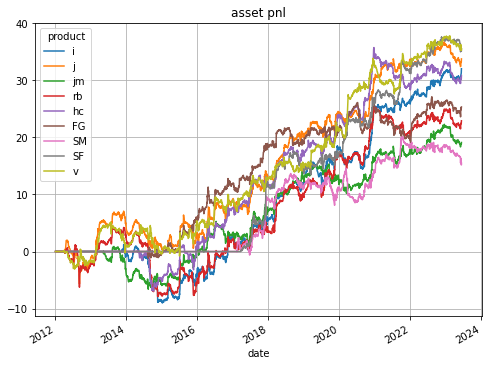

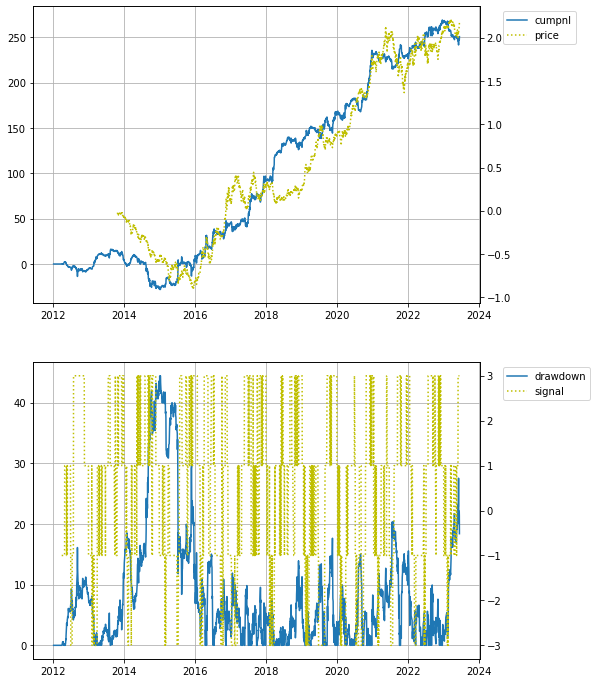

In [56]:
signal_ts = signal_ts.reindex(index=cdays).ffill().reindex(index=df_pxchg.index)
signal_df = pd.DataFrame(dict([(asset, signal_ts.shift(1)) for asset in empiric_assets]))

holding = generate_holding_from_signal(signal_df, vol_df, risk_scaling=1.0, asset_scaling=False)
bt_metrics = MetricsBase(holdings=holding[empiric_assets][cutoff:],
                         returns=df_pxchg[empiric_assets][cutoff:])

pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors)

print(pnl_stats['sharpe'])
print(pnl_stats['asset_sharpe_stats'])

print(pd.DataFrame({key: pnl_stats[key] for key in ['pnl_per_trade', 'turnover']}))

pnl_stats['asset_cumpnl'].plot(figsize=(8,6))
plt.grid()
plt.title('asset pnl')

plot_signal_pnl(pnl_stats['portfolio_cumpnl'], signal=signal_ts, asset_price=df_pxchg[empiric_assets[0]].cumsum(), figsize=(8, 12))


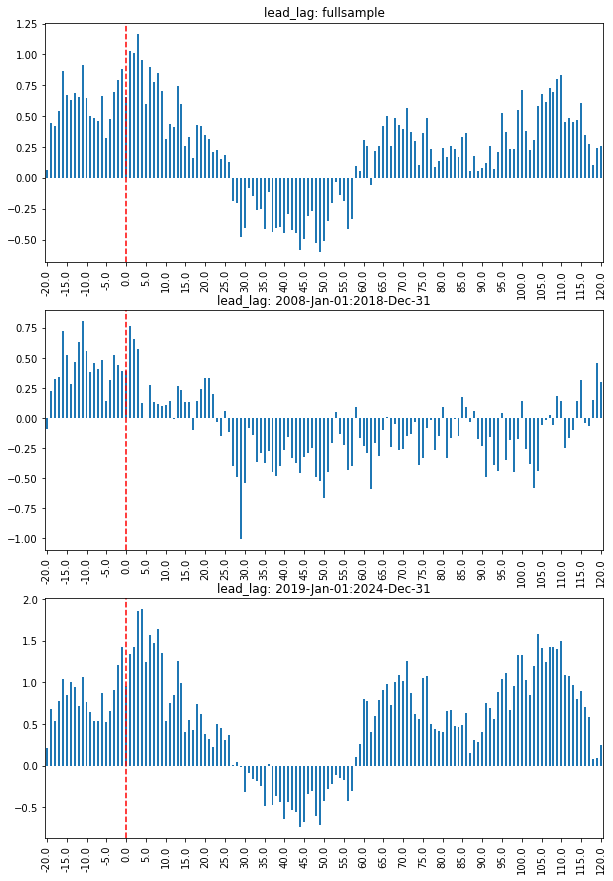

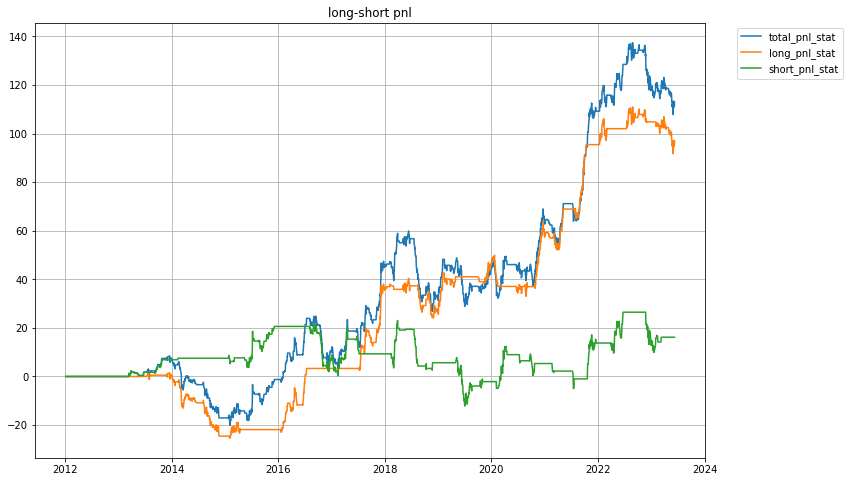

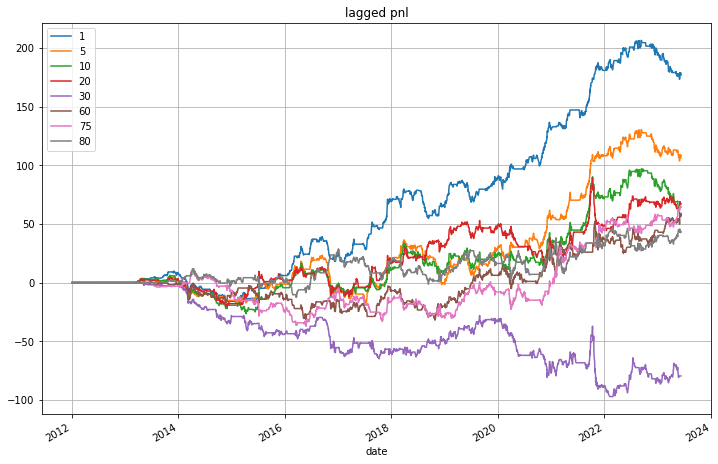

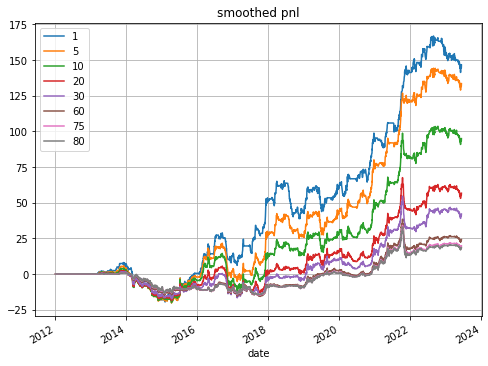

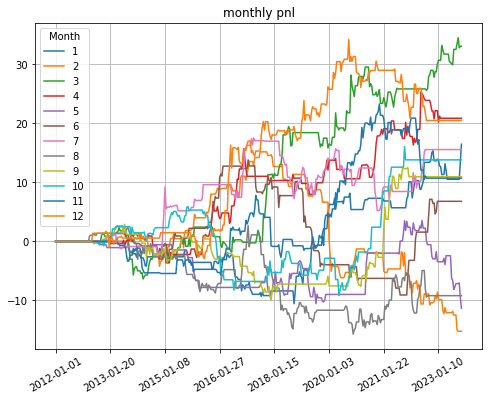

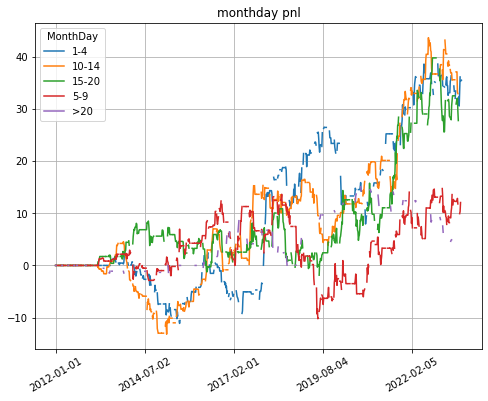

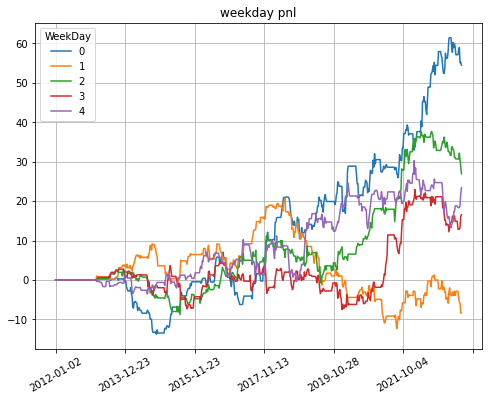

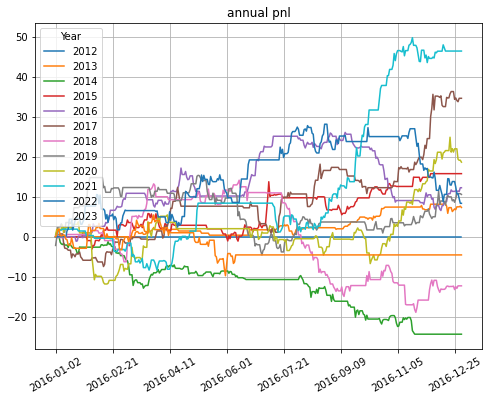

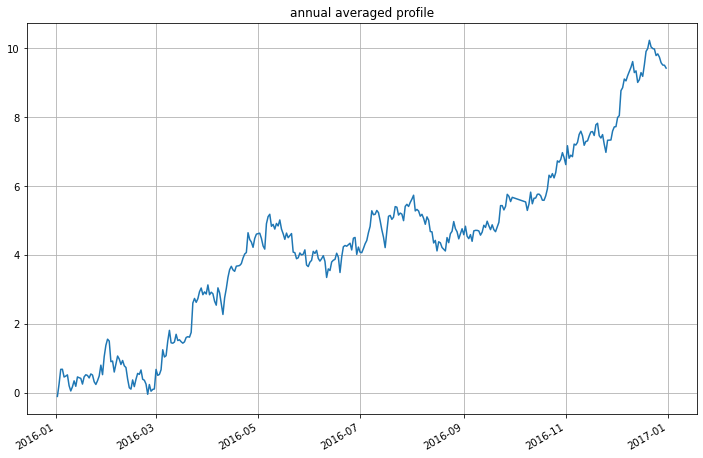

In [28]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2018, 12, 31)), 
                   (datetime.date(2019, 1, 1), datetime.date(2024, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


ll_left = lead_lag_config['ll_left']
ll_right = lead_lag_config['ll_right']
spacing = lead_lag_config['ll_spacing']

leadlag_df = bt_metrics.lead_lag(ll_limit_left=ll_left, 
                                 ll_limit_right=ll_right,
                                 ll_sub_windows=lead_lag_config['ll_sub_win'])

fig, ax = plt.subplots(len(ll_keys), 1)
fig.set_figheight(15)
fig.set_figwidth(10)

for i, key in enumerate(ll_keys):
    ts = leadlag_df['leadlag_sharpes'].loc[key]
    ts.plot(kind='bar', ax = ax[i], title = f'lead_lag: {key}')
    new_ticks = np.linspace(ll_left, ll_right, (ll_right-ll_left)//spacing+1)
    ax[i].set_xticks(np.interp(new_ticks, ts.index, np.arange(ts.size)))
    ax[i].set_xticklabels(new_ticks)
    ax[i].axvline(x=-ll_left, color='red', linestyle='--')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ls_pnl = bt_metrics.long_short_pnl()
for key in ls_pnl:
    ax.plot(ls_pnl[key]['portfolio_cumpnl'].index, ls_pnl[key]['portfolio_cumpnl'].values, '-', label=key)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, bbox_to_anchor=(1.04, 1), loc='upper left')
ax.grid()
plt.title("long-short pnl")
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
#print('lagged PNL\n', lagged['sharpe'])
plt.grid()
plt.title('lagged pnl')
plt.show()

smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(8, 6))
#print('smoothed PNL\n', smoothed['sharpe'])
plt.grid()
plt.title('smoothed pnl')
plt.show()

#tilt_timing = bt_metrics.tilt_timing(tilt_rolling_window=1*244) # default 3 years  tilt_rolling_window = 3 * 244 

seasonal_pnl = bt_metrics.seasonal_pnl()
cumpnl = seasonal_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('seasonal sharpe stats\n', seasonal_pnl['sharpe_stats'])
plt.grid()
plt.title('monthly pnl')
plt.show()


monthday_pnl = bt_metrics.monthday_pnl()
cumpnl = monthday_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('monthday sharpe stats\n', monthday_pnl['sharpe_stats'])
plt.grid()
plt.title('monthday pnl')
plt.show()


week_pnl = bt_metrics.week_pnl()
cumpnl = week_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('week sharpe stats\n', week_pnl['sharpe_stats'])
plt.grid()
plt.title('weekday pnl')
plt.show()


annual_pnl = bt_metrics.annual_pnl()
cumpnl = annual_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('annual sharpe stats\n', annual_pnl['sharpe_stats'])
plt.grid()
plt.title('annual pnl')
plt.show()

annual_pnl['cumlog_pnl'].mean(axis=1).plot()
plt.grid()
plt.title('annual averaged profile')
plt.show()

# turnover = bt_metrics.turnover()
# print(turnover)

# batch feature exploration

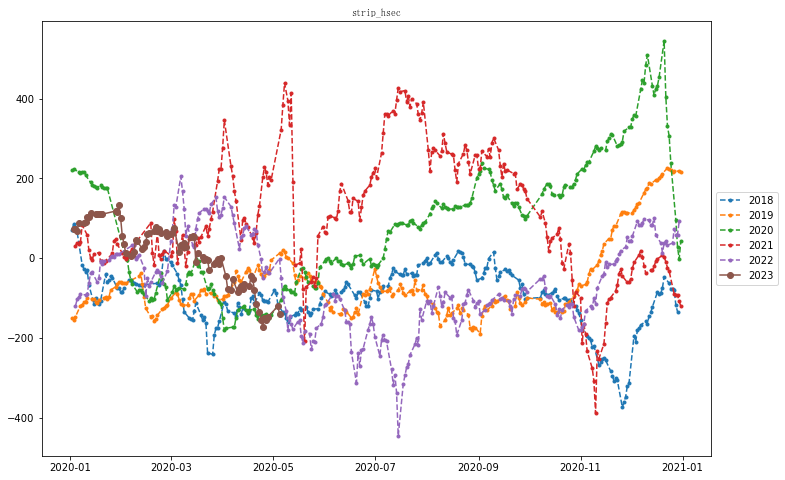

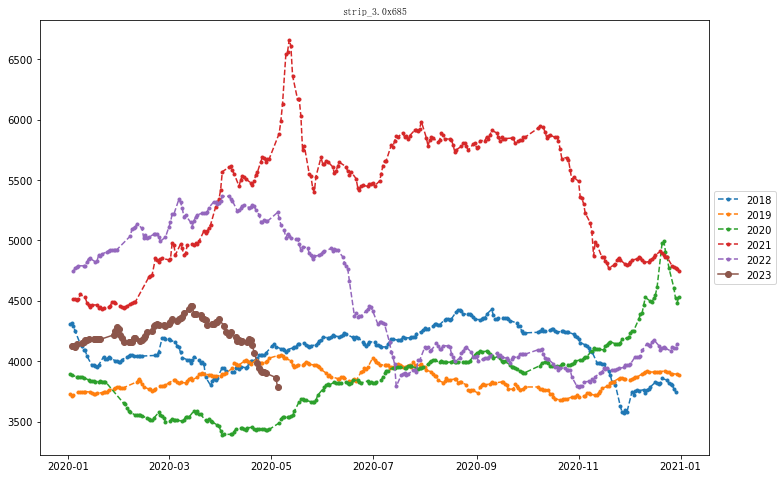

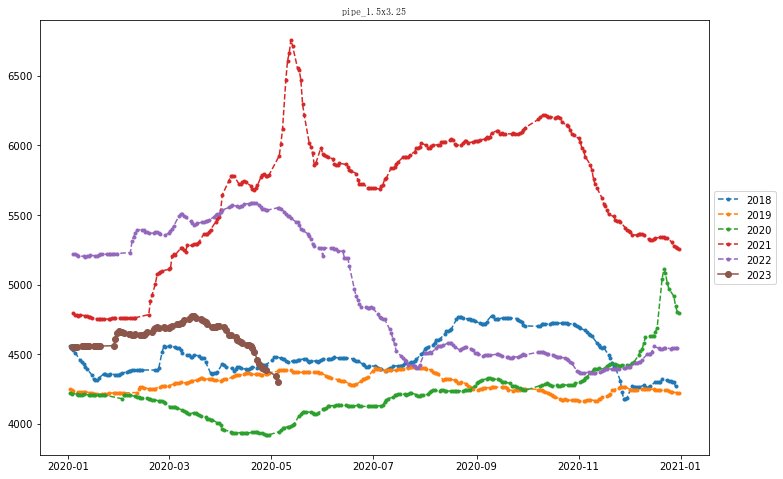

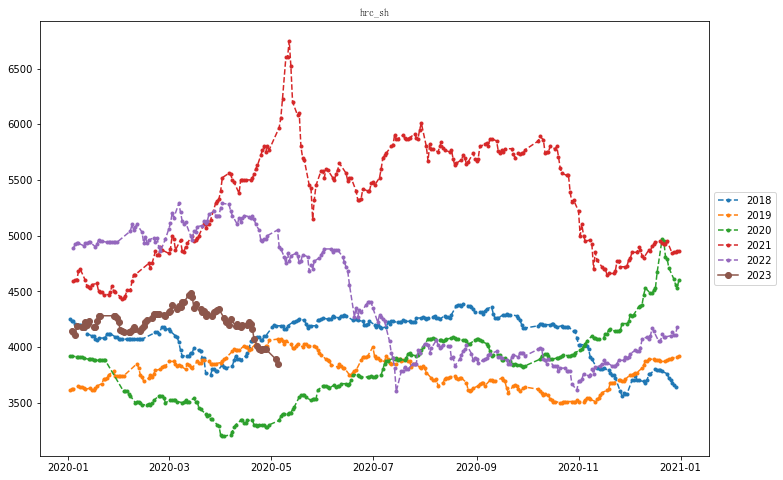

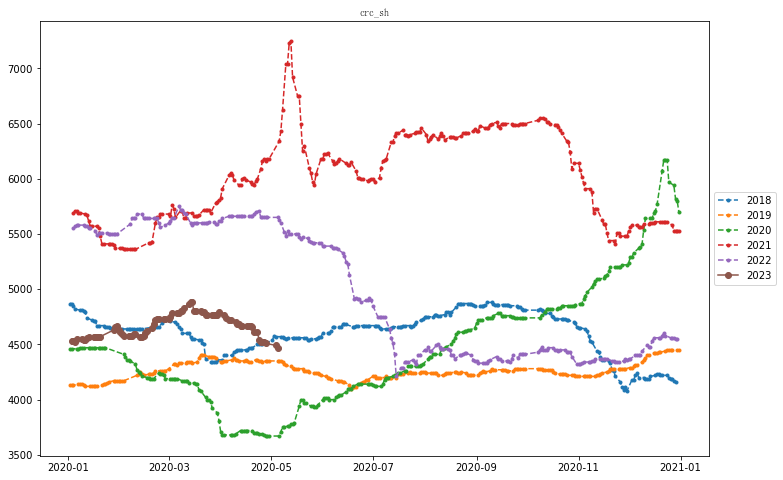

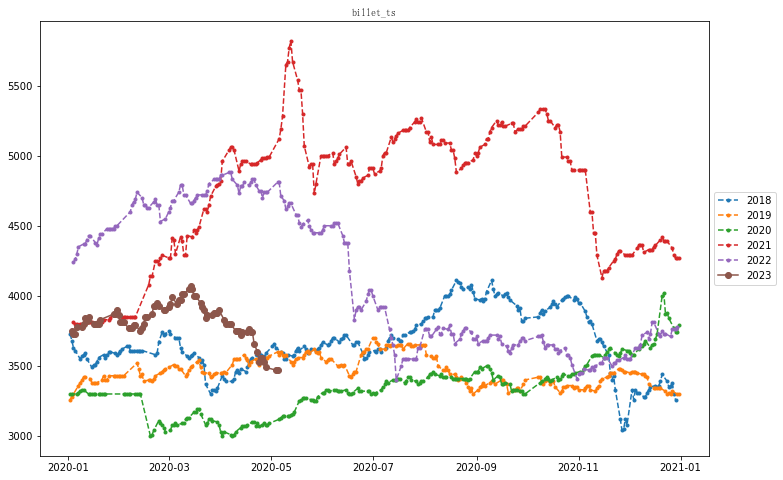

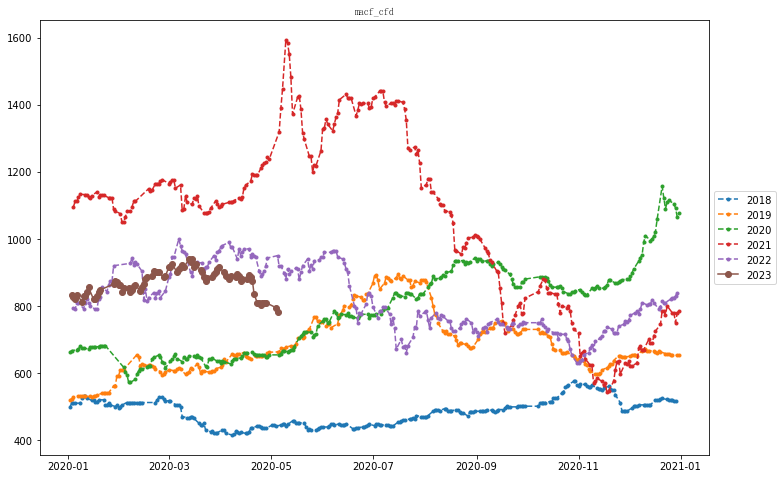

In [116]:
feature_list = [
#     'margin_hrc_sh', 
    'strip_hsec',
    'strip_3.0x685',
    'pipe_1.5x3.25',    
    'hrc_sh',
    'crc_sh',
    'billet_ts',
    'macf_cfd',
#     'gi_0.5_sh',
#     'hsec_400x200',
#     'highwire_6.5',
#     'angle_50x5',
#     'ibeam_25',
#     'channel_16',

#     'import_arb', 'pbf_prem', 'plt65_62',
#     'io_laytime_45ports', 'io_inv_imp_31ports',
#     'io_invdays_imp_mill(64)', 'io_inv_mill(64)', 'io_inv_imp_mill',
#     'io_removal_port_41',
#     'io_loading_14ports_ausbzl',
]

udf = spot_df[feature_list].dropna(how='all')
# lunar_seasonal = True

# if lunar_seasonal:
#     seasonal_signal = tstool.lunar_label(udf)
#     seasonal_signal = tstool.seasonal_group_score(
#         seasonal_signal, score_cols=feature_list, yr_col='lunar_cny',
#         group_col='lunar_wks', min_obs=3, backward=2, forward=2, rolling_years=3)
#     seasonal_signal = seasonal_signal.reindex(index=df.index).ffill()

for feature in udf.columns:
    dataseries.plot_seasonal_df(udf[feature].dropna(), cutoff='2018-01-01', title=feature)
    
signal_raw = udf[feature_list].reindex(index=df.index).ffill()


rb:strip_hsec -> SR: 1.00 -- PNL per trade: 33.08 -- Turnover: 26.72
rb:strip_3.0x685 -> SR: 1.07 -- PNL per trade: 55.20 -- Turnover: 17.46
rb:pipe_1.5x3.25 -> SR: 0.85 -- PNL per trade: 53.25 -- Turnover: 14.26
rb:hrc_sh -> SR: 1.11 -- PNL per trade: 46.67 -- Turnover: 21.92
rb:crc_sh -> SR: 1.03 -- PNL per trade: 60.39 -- Turnover: 15.17
rb:billet_ts -> SR: 0.85 -- PNL per trade: 30.21 -- Turnover: 26.18
rb:macf_cfd -> SR: 1.18 -- PNL per trade: 77.03 -- Turnover: 13.00


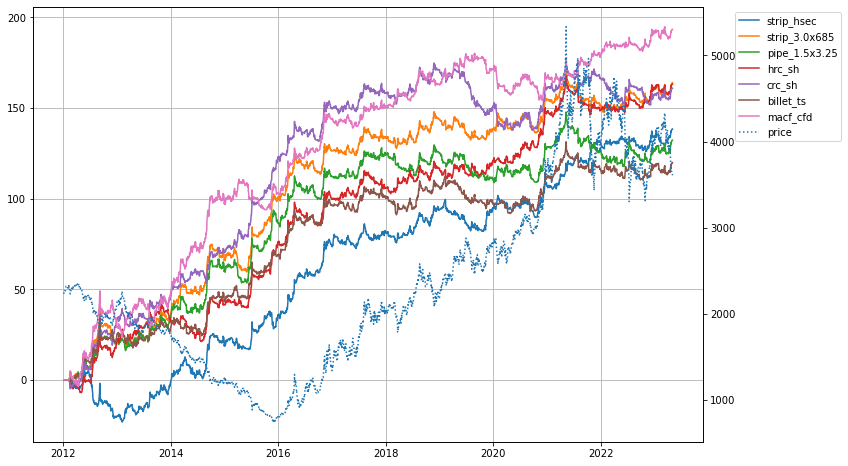

hc:strip_hsec -> SR: 1.25 -- PNL per trade: 42.52 -- Turnover: 28.27
hc:strip_3.0x685 -> SR: 0.96 -- PNL per trade: 49.43 -- Turnover: 19.23
hc:pipe_1.5x3.25 -> SR: 0.72 -- PNL per trade: 49.98 -- Turnover: 13.95
hc:hrc_sh -> SR: 1.26 -- PNL per trade: 54.48 -- Turnover: 23.52
hc:crc_sh -> SR: 0.87 -- PNL per trade: 53.23 -- Turnover: 16.00
hc:billet_ts -> SR: 0.71 -- PNL per trade: 27.15 -- Turnover: 26.33
hc:macf_cfd -> SR: 0.89 -- PNL per trade: 48.24 -- Turnover: 17.91


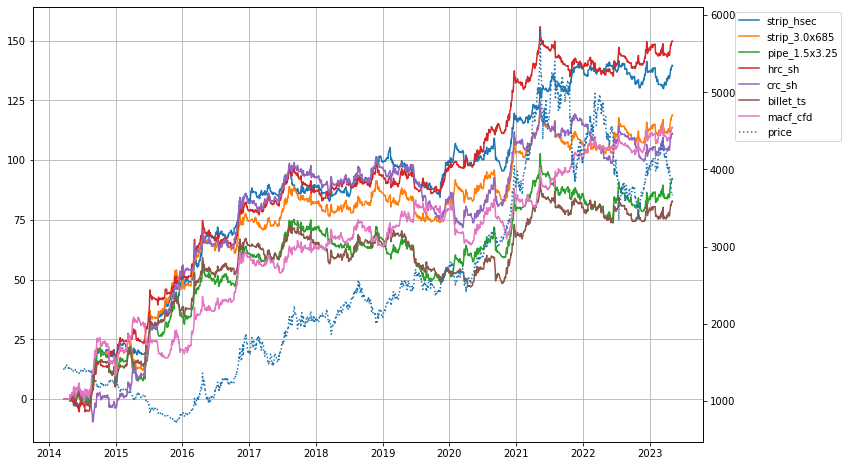

i:strip_hsec -> SR: 1.37 -- PNL per trade: 74.96 -- Turnover: 26.70
i:strip_3.0x685 -> SR: 1.02 -- PNL per trade: 81.14 -- Turnover: 18.90
i:pipe_1.5x3.25 -> SR: 0.76 -- PNL per trade: 79.20 -- Turnover: 14.08
i:hrc_sh -> SR: 1.05 -- PNL per trade: 70.10 -- Turnover: 23.09
i:crc_sh -> SR: 0.73 -- PNL per trade: 67.10 -- Turnover: 16.17
i:billet_ts -> SR: 0.85 -- PNL per trade: 49.90 -- Turnover: 26.78
i:macf_cfd -> SR: 1.52 -- PNL per trade: 132.16 -- Turnover: 16.51


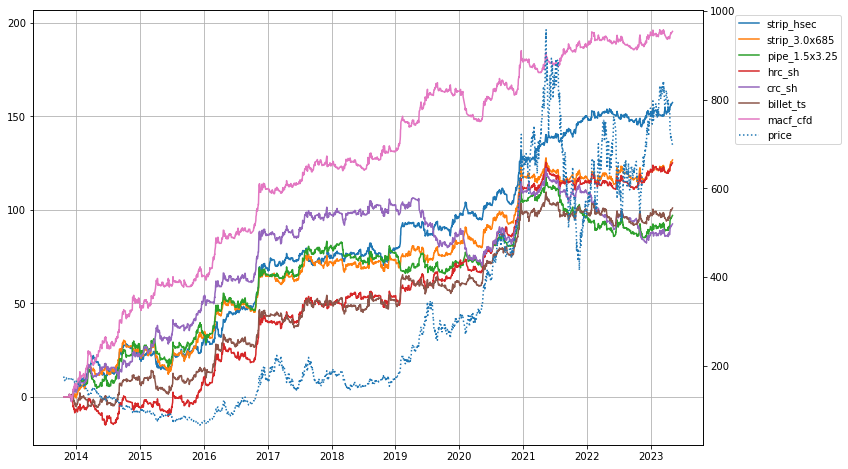

j:strip_hsec -> SR: 1.26 -- PNL per trade: 53.79 -- Turnover: 27.92
j:strip_3.0x685 -> SR: 1.37 -- PNL per trade: 89.78 -- Turnover: 17.88
j:pipe_1.5x3.25 -> SR: 1.49 -- PNL per trade: 121.06 -- Turnover: 14.14
j:hrc_sh -> SR: 1.07 -- PNL per trade: 59.06 -- Turnover: 22.09
j:crc_sh -> SR: 1.50 -- PNL per trade: 115.20 -- Turnover: 15.14
j:billet_ts -> SR: 1.23 -- PNL per trade: 56.59 -- Turnover: 26.66
j:macf_cfd -> SR: 1.32 -- PNL per trade: 109.48 -- Turnover: 13.21


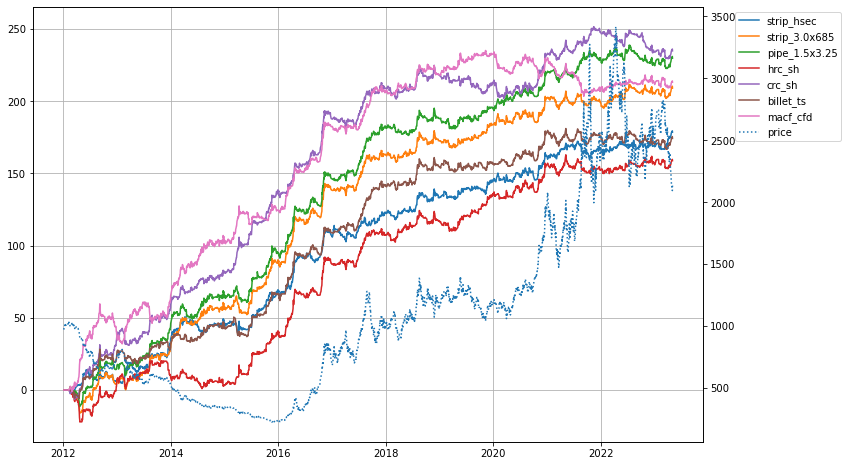

jm:strip_hsec -> SR: 1.11 -- PNL per trade: 47.05 -- Turnover: 27.42
jm:strip_3.0x685 -> SR: 1.10 -- PNL per trade: 69.23 -- Turnover: 18.61
jm:pipe_1.5x3.25 -> SR: 1.11 -- PNL per trade: 91.50 -- Turnover: 13.80
jm:hrc_sh -> SR: 0.74 -- PNL per trade: 38.50 -- Turnover: 23.06
jm:crc_sh -> SR: 1.26 -- PNL per trade: 93.10 -- Turnover: 15.35
jm:billet_ts -> SR: 0.85 -- PNL per trade: 37.64 -- Turnover: 27.50
jm:macf_cfd -> SR: 0.93 -- PNL per trade: 65.74 -- Turnover: 15.77


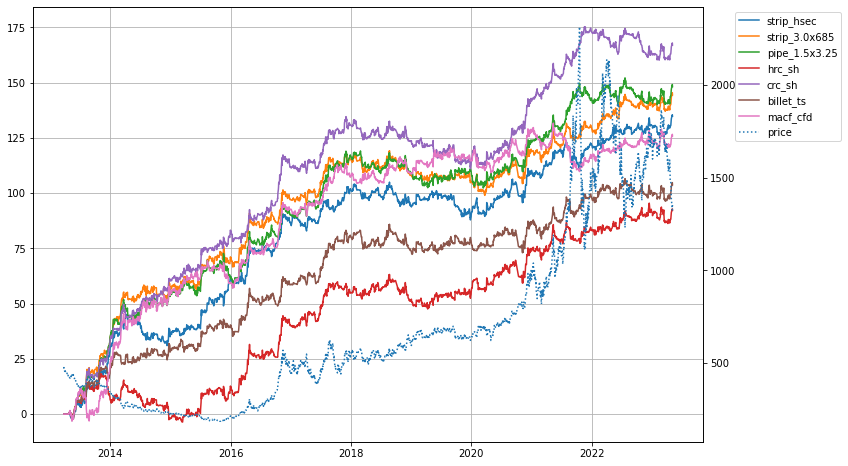

SF:strip_hsec -> SR: 0.18 -- PNL per trade: 6.28 -- Turnover: 30.83
SF:strip_3.0x685 -> SR: 0.70 -- PNL per trade: 35.25 -- Turnover: 21.70
SF:pipe_1.5x3.25 -> SR: 0.89 -- PNL per trade: 61.14 -- Turnover: 15.48
SF:hrc_sh -> SR: 0.94 -- PNL per trade: 42.61 -- Turnover: 24.70
SF:crc_sh -> SR: 1.28 -- PNL per trade: 86.06 -- Turnover: 15.70
SF:billet_ts -> SR: 0.69 -- PNL per trade: 28.08 -- Turnover: 27.31
SF:macf_cfd -> SR: 0.66 -- PNL per trade: 31.76 -- Turnover: 22.86


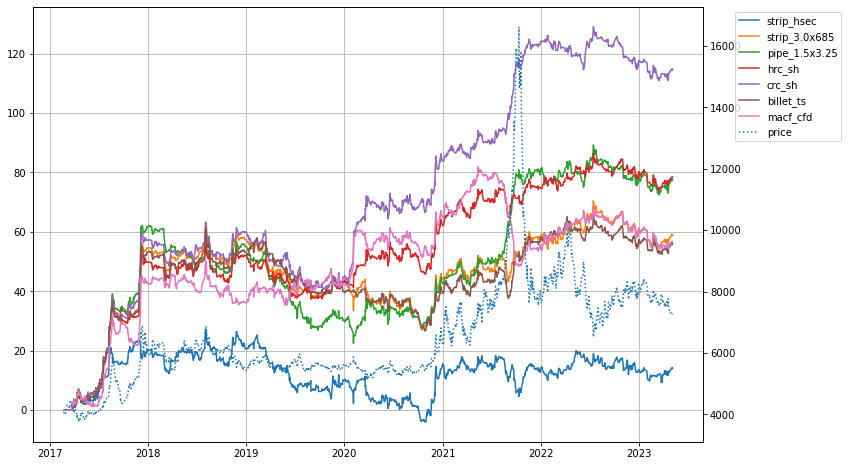

FG:strip_hsec -> SR: 1.09 -- PNL per trade: 38.09 -- Turnover: 29.64
FG:strip_3.0x685 -> SR: 0.48 -- PNL per trade: 25.14 -- Turnover: 20.07
FG:pipe_1.5x3.25 -> SR: 0.31 -- PNL per trade: 21.01 -- Turnover: 14.80
FG:hrc_sh -> SR: 0.87 -- PNL per trade: 38.18 -- Turnover: 23.47
FG:crc_sh -> SR: 0.40 -- PNL per trade: 24.92 -- Turnover: 16.19
FG:billet_ts -> SR: 0.76 -- PNL per trade: 29.74 -- Turnover: 26.37
FG:macf_cfd -> SR: 0.65 -- PNL per trade: 33.69 -- Turnover: 19.86


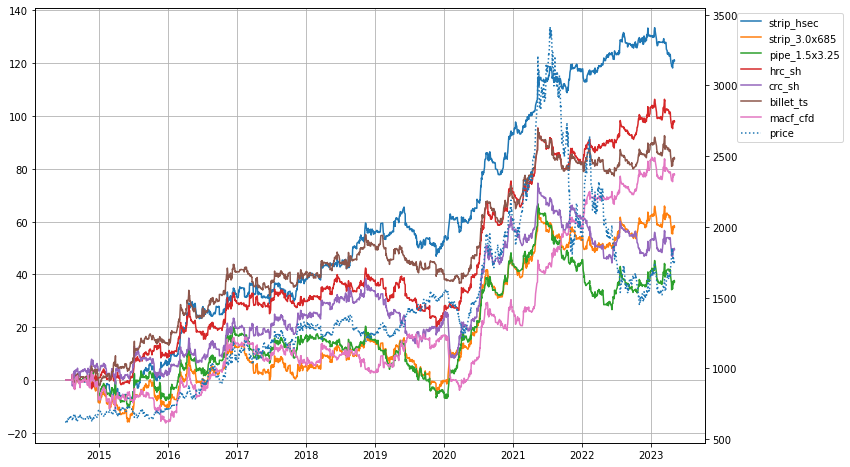

In [118]:
cutoff = '2012-01-01'
signal_func = 'qtl'
param_rng = [20, 42, 2]
signal_cap = None # [-2, 2]
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'SF', 'FG', ] # 'v', 'cu', 'al', 'ss', 'UR', 'SA', 'ru'

for asset in product_list:
    if '_' in asset:
        price_ts = (1 + beta_ret_dict[asset]).cumprod().to_frame('price')[cutoff:]
    else:
        price_ts = df[(asset, 'c1', 'close')].dropna().to_frame('price')[cutoff:]
    pnl_list = [price_ts]
    for feature in feature_list:
        feature_ts = udf[feature].reindex(index=price_ts.index).ffill()
        #feature_ts = feature_ts.pct_change(5)
        #feature_ts = tstool.lunar_yoy(feature_ts, group_col='lunar_days', func='pct_change')
        #feature_ts = tstool.seasonal_score(feature_ts.to_frame())
        signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
        asset_df = pd.concat([price_ts, signal_ts], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price'])
        asset_df['position'] = (asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset}:{feature} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        pnl_list.append(asset_df['pnl'].cumsum().to_frame(feature))
    pnl_df = pd.concat(pnl_list, axis=1)
    dataseries.plot_df_on_2ax(pnl_df, left_on=feature_list, right_on=['price'])
    

# signal grid search run

In [ ]:
signal_list = []

for feature in feature_list:
    for win in [20, 40, 60, 80, 120, 240]:
        signal_name = f"{feature}:ma:{win}"
        signal_raw[signal_name] = signal_raw[feature] - signal_raw[feature].rolling(win).mean()
        signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
        signal_list.append(signal_name)
        
        signal_name = f"{feature}:ewmac:{win}"
        signal_raw[signal_name] = dh.ewmac(signal_raw[feature], win_s=win/10, ls_ratio=2)
        signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
        signal_list.append(signal_name)

#         signal_name = f"{feature}:convewm:{win}"
#         signal_raw[signal_name] = dh.conv_ewm(signal_raw[feature], h1s=[win//10, win//10*2], h2s=[win//10*3, win//10*6])
#         signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
#         signal_list.append(signal_name)
        
        signal_name = f"{feature}:zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:zscore_dff20:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature].diff(20), win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl_dff20:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature].diff(20), win=win)*2
        signal_list.append(signal_name)
        
        signal_name = f"{feature}:lunar_wks_score:{win}"
        signal_raw[signal_name] = seasonal_signal[feature]
        signal_list.append(signal_name)
        
        signal_prefix = f"{feature}:seasonal_score"
        signal_raw[signal_prefix] = tstool.seasonal_score(signal_raw[feature].to_frame())
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)
        
        signal_prefix = f"{feature}:yoy"
        signal_raw[signal_prefix] = signal_raw[feature]/signal_raw[feature].shift(244)-1
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)

        signal_prefix = f"{feature}:lunar_yoy"
        signal_raw[signal_prefix] = tstool.lunar_yoy(signal_raw[feature], group_col='lunar_days', func='pct_change')
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)
        
signal_raw = signal_raw.reindex(index=df.index).ffill()

In [ ]:
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'v', 'FG', 'SM', 'SF']
cutoff = pd.Timestamp('2012-07-01')

for sig in signal_list:
    print(sig)
    pnl_by_asset = {}
    pnl_df = pd.DataFrame()
    pos_df = pd.DataFrame()
    for asset in product_list:
        signal = signal_raw[sig]
        asset_df = pd.concat([df[(asset, 'c1', 'close')], signal], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price']).ffill()
        asset_df['position'] = (asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        
        pnl_by_asset[asset] = asset_df
        pnl_df[asset] = asset_df['pnl']
        pos_df[asset] = asset_df['position']
    pnl_df = pnl_df.fillna(0)
    pos_df = pos_df.ffill()
    total_sr = = np.sqrt(244) * pnl_df.sum(axis=1).mean()/pnl_df.sum(axis=1).std()
    print(f'Total SR: {total_sr:.2f}')
    
    cumpn; = pnl_df.cumsum()
    cumpnl.plot()
    plt.title(sig)
    plt.show()
    cum_pnl.sum(axis=1).plot()
    plt.title(sig)
    plt.show()
    

# Signal portfolio

In [111]:
signal_dict_full = {
    'i': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 0.5),
        #('io_inv_mill(64)_lyoy_mom', 0.5),
        
        ('io_invdays_imp_mill(64)_lvl_fast', 0.5),
        #('io_invdays_imp_mill(64)_lyoy_mom', 0.5),
        
#         ('steel_social_inv_lvl_fast', 1.0/1.0),
#         ('rebar_inv_social_lyoy_fast', 0.25/1.0),
#         ('wirerod_inv_social_lyoy_fast', 0.25/1.0),
#         ('hrc_inv_social_lyoy_fast', 0.25/1.0),
#         ('crc_inv_social_lyoy_fast', 0.25/1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),
        ('macf_cfd_lvl_mid', 1.0),
#         ('pbf_prem_yoy', 0.5/15),
#         ('cons_steel_lyoy_slow', 1.0/1.5),
#         ('sea_export_arb_lvl_mid', 1.0/1.4),
    ],
    'rb': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('rebar_inv_social_lyoy_fast', 1.0),
#         ('wirerod_inv_social_lyoy_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
    'hc': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('hrc_inv_social_lyoy_fast', 1.0),
#         ('crc_inv_social_lyoy_fast', 1.0),        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),  
    ],
    'j': [
        #('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('steel_social_inv_lvl_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
    'jm': [
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('steel_social_inv_lvl_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),     
    ],
    'FG': [
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
}

i:io_removal_lvl_fast -> SR: 1.44 -- PNL per trade: 125.18 -- Turnover: 16.32
i:io_inv_mill(64)_lvl_fast -> SR: 1.06 -- PNL per trade: 124.63 -- Turnover: 12.02
i:io_invdays_imp_mill(64)_lvl_fast -> SR: 1.08 -- PNL per trade: 96.53 -- Turnover: 16.77
i:margin_lvl_fast -> SR: 1.41 -- PNL per trade: 98.64 -- Turnover: 20.34
i:strip_hsec_lvl_mid -> SR: 1.35 -- PNL per trade: 101.73 -- Turnover: 19.64
i:macf_cfd_lvl_mid -> SR: 1.24 -- PNL per trade: 150.45 -- Turnover: 12.07
i:total -> SR: 1.92 -- PNL per trade: 173.72 -- Turnover: 17.79
io_removal_lvl_fast                 0.829607
io_inv_mill(64)_lvl_fast            0.438992
io_invdays_imp_mill(64)_lvl_fast    0.402572
margin_lvl_fast                     0.849863
strip_hsec_lvl_mid                  0.776010
macf_cfd_lvl_mid                    0.864912
dtype: float64


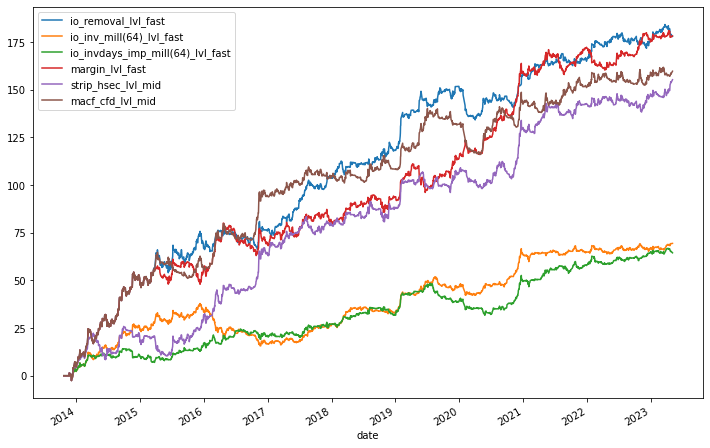

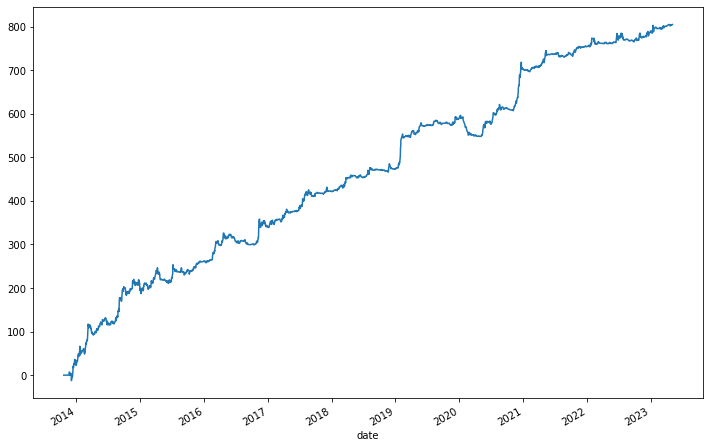

rb:io_removal_lvl_fast -> SR: 1.14 -- PNL per trade: 82.35 -- Turnover: 10.73
rb:io_inv_mill(64)_lvl_fast -> SR: 0.90 -- PNL per trade: 81.30 -- Turnover: 8.63
rb:margin_lvl_fast -> SR: 1.13 -- PNL per trade: 67.99 -- Turnover: 12.88
rb:strip_hsec_lvl_mid -> SR: 0.88 -- PNL per trade: 39.16 -- Turnover: 19.54
rb:total -> SR: 1.30 -- PNL per trade: 87.76 -- Turnover: 12.28
io_removal_lvl_fast         0.941461
io_inv_mill(64)_lvl_fast    0.974576
margin_lvl_fast             0.951824
strip_hsec_lvl_mid          0.813721
dtype: float64


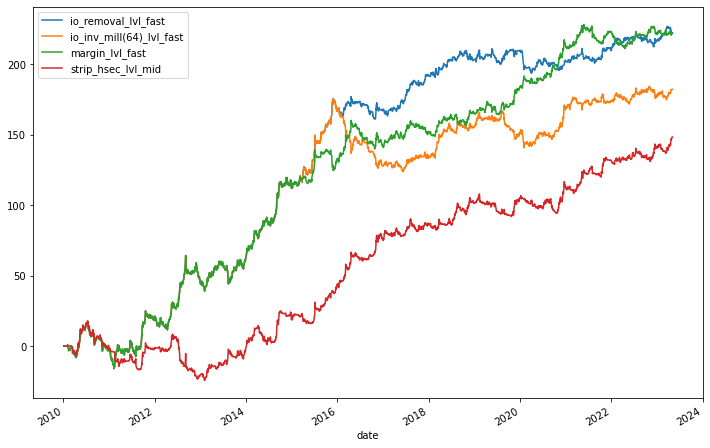

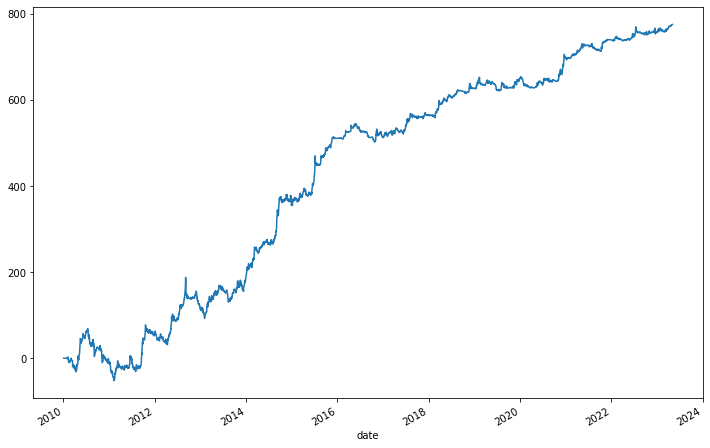

hc:io_removal_lvl_fast -> SR: 1.11 -- PNL per trade: 59.73 -- Turnover: 17.62
hc:io_inv_mill(64)_lvl_fast -> SR: 0.77 -- PNL per trade: 55.45 -- Turnover: 13.05
hc:margin_lvl_fast -> SR: 1.10 -- PNL per trade: 47.66 -- Turnover: 22.04
hc:strip_hsec_lvl_mid -> SR: 1.34 -- PNL per trade: 62.48 -- Turnover: 21.46
hc:total -> SR: 1.54 -- PNL per trade: 78.61 -- Turnover: 20.48
io_removal_lvl_fast         0.852830
io_inv_mill(64)_lvl_fast    0.902805
margin_lvl_fast             0.871381
strip_hsec_lvl_mid          0.780406
dtype: float64


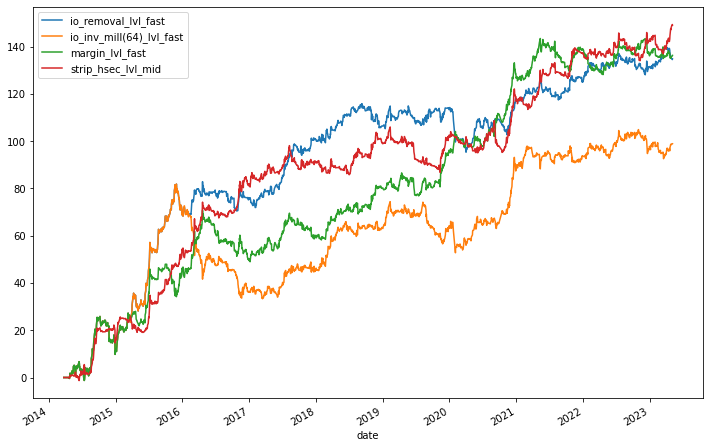

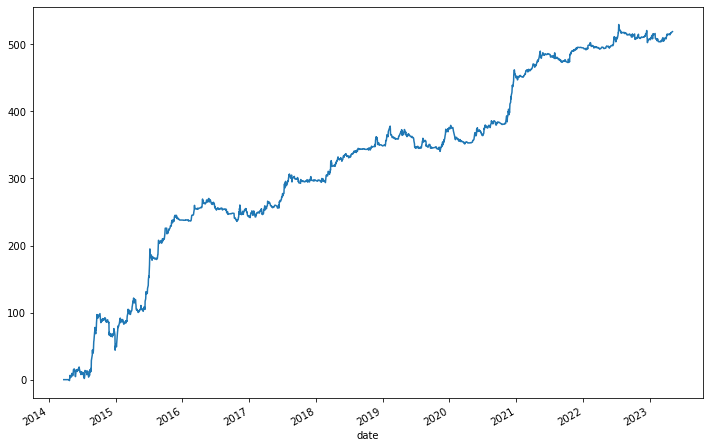

j:margin_lvl_fast -> SR: 1.72 -- PNL per trade: 123.09 -- Turnover: 14.65
j:strip_hsec_lvl_mid -> SR: 1.35 -- PNL per trade: 71.61 -- Turnover: 21.87
j:total -> SR: 1.84 -- PNL per trade: 111.75 -- Turnover: 20.35
margin_lvl_fast       0.940847
strip_hsec_lvl_mid    0.792106
dtype: float64


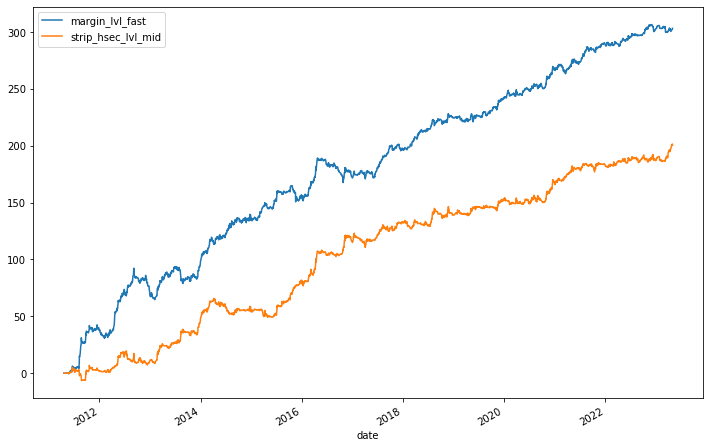

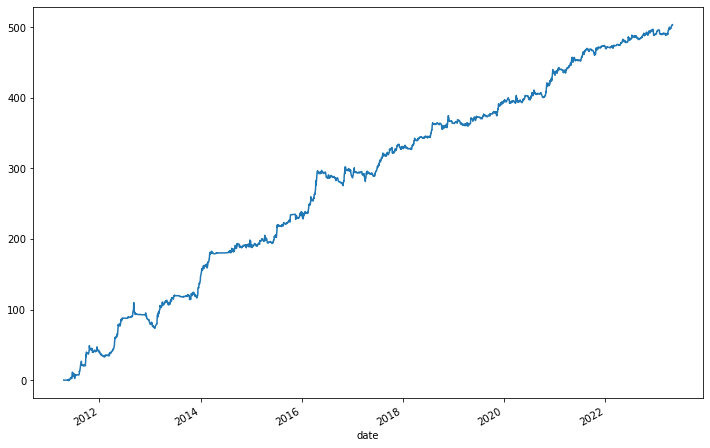

jm:margin_lvl_fast -> SR: 1.19 -- PNL per trade: 70.76 -- Turnover: 18.68
jm:strip_hsec_lvl_mid -> SR: 1.32 -- PNL per trade: 76.23 -- Turnover: 20.36
jm:total -> SR: 1.48 -- PNL per trade: 84.74 -- Turnover: 21.66
margin_lvl_fast       0.854962
strip_hsec_lvl_mid    0.761956
dtype: float64


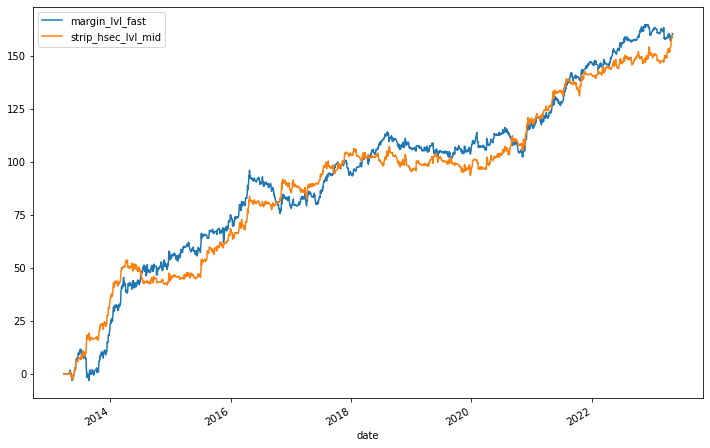

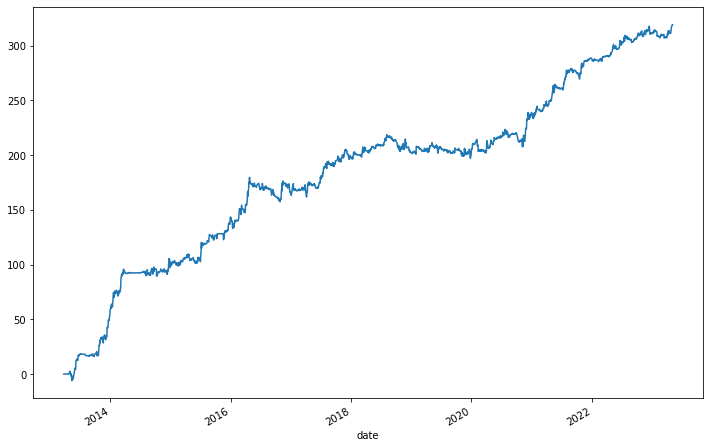

In [112]:
signal_dict = signal_dict_full

signal_diagnosis = False

pnl_dict = {}
pos_dict = {}

for asset in ['i', 'rb', 'hc', 'j', 'jm']:
    if '_' in asset:
        price_ts = (1 + beta_ret_dict[asset]).cumprod().to_frame('price')
    else:
        price_ts = df[(asset, 'c1', 'close')].dropna().to_frame('price')
    pnl_list = []
    pos_list = []
    for idx, (feature_name, weight) in enumerate(signal_dict[asset]):
        feature, signal_func, param_rng, proc_func, chg_func, bullish, freq = signal_repo[feature_name]
        if freq == 'price':
            feature_ts = spot_df[feature].ffill().reindex(index=price_ts.index).ffill()
        elif len(freq) > 0:
            feature_ts = spot_df[feature].ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)).ffill()
        else:
            feature_ts = spot_df[feature].dropna()
        
        if 'yoy' in proc_func:
            if 'lunar' in proc_func:
                label_func = lunar_label
                label_args = {}
            else:
                label_func = calendar_label
                label_args = {'anchor_date': {'month': 1, 'day': 1}}
            if '_wk' in proc_func:
                group_col = 'label_wk'
            else:
                group_col = 'label_day'
            feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col='label_day', func=chg_func, label_args=label_args)
        elif 'df' in proc_func:
            n_diff = int(proc_func[2:])
            feature_ts = getattr(feature_ts, chg_func)(n_diff)
    
        if signal_func == 'seasonal_score_w':
            signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10).reindex(index=df.index).ffill()
        elif signal_func == 'seasonal_score_d':
            signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
        elif len(signal_func)>0:
            feature_ts = feature_ts.reindex(index=df.index).ffill()
            signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
        else:
            signal_ts = feature_ts.reindex(index=df.index).ffill()
            
        if not bullish:
            signal_ts = -signal_ts
            
        asset_df = pd.concat([price_ts, signal_ts], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price'])
        asset_df['position'] = (weight*asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        std = asset_df['pnl'].std()
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset}:{feature_name} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        pnl_list.append(asset_df['pnl'].to_frame(feature_name))
        pos_list.append(asset_df['position'].to_frame(feature_name))
        
    pnl_df = pd.concat(pnl_list, axis=1)
    pos_df = pd.concat(pos_list, axis=1)
    sum_pnl = pnl_df.sum(axis=1)
    sum_pos = pos_df.sum(axis=1)
    sr = np.sqrt(244) * sum_pnl.mean()/sum_pnl.std()
    pnl_per_trade = 100 * 100 * sum_pnl.mean()/sum_pos.diff().abs().mean()
    turnover = 100 * sum_pos.diff().abs().mean()/sum_pos.abs().mean()
    print(f'{asset}:total -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
    
    print(pnl_df.std())
    pnl_dict[asset] = pnl_df
    pos_dict[asset] = pos_df
    pnl_df.cumsum().plot()
    plt.show()
    sum_pnl.cumsum().plot()
    plt.show()


In [10]:
fill_backward = False
smooth_win = 1
sig_smooth = tstool.exp_smooth(df_in, hl = smooth_win, fill_backward=fill_backward)

demean = False
mean_win = 244
vol_win = 244
if demean:
    sig_scored = tstool.ts_score(sig_smooth, hl_mean=mean_win, min_obs_mean=mean_win, fill_backward_mean=fill_backward, 
                          hl_vol=vol_win, min_obs_vol=vol_win, fill_backward_vol=fill_backward)
else:
    sig_scored = tstool.ts_scale(sig_smooth, hl = vol_win, min_obs=vol_win, fill_backward=fill_backward)

#sig_scored = tstool.xs_score(sig_smooth, demean=demean, hl=vol_win)

signal_cap = 2.0

score_capped = tstool.cap(sig_scored, -signal_cap, signal_cap)
score_filled = tstool.filldown(score_capped, 2)
score = tstool.lag(score_filled, 1)


In [ ]:
vol_scale = 20
asset_vol = tstool.exp_smooth(df_pxchg**2, hl=vol_scale, fill_backward=fill_backward)**0.5
holding = score/asset_vol

commod_list = holding.columns #['hc']
btmetrics = MetricsBase(holdings = holding[commod_list], returns = df_pxchg[commod_list])